In [1]:
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import Callback
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
# Load the dataset
data = pd.read_csv(Path('Training_Fraudulent_E-Commerce_Transaction_Data.csv'))

# Review the DataFrame
print(data.nunique())
data.head()


Transaction ID        1472952
Customer ID           1472952
Transaction Amount     109257
Transaction Date      1346684
Payment Method              4
Product Category            5
Quantity                    5
Customer Age               97
Customer Location       99135
Device Used                 3
IP Address            1472651
Shipping Address      1472948
Billing Address       1472949
Is Fraudulent               2
Account Age Days          365
Transaction Hour           24
dtype: int64


,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",0,63,3
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",0,124,20
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",0,158,5


In [3]:
# Display dataset structure
print(data.info())

# View the first few rows
print(data.head())

# Check for missing values
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472952 entries, 0 to 1472951
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Transaction ID      1472952 non-null  object 
 1   Customer ID         1472952 non-null  object 
 2   Transaction Amount  1472952 non-null  float64
 3   Transaction Date    1472952 non-null  object 
 4   Payment Method      1472952 non-null  object 
 5   Product Category    1472952 non-null  object 
 6   Quantity            1472952 non-null  int64  
 7   Customer Age        1472952 non-null  int64  
 8   Customer Location   1472952 non-null  object 
 9   Device Used         1472952 non-null  object 
 10  IP Address          1472952 non-null  object 
 11  Shipping Address    1472952 non-null  object 
 12  Billing Address     1472952 non-null  object 
 13  Is Fraudulent       1472952 non-null  int64  
 14  Account Age Days    1472952 non-null  int64  
 15  Transaction Hou

In [4]:
# Drop irrelevant columns
data_cleaned = data.drop(columns=['Transaction ID', 'Customer ID', 'IP Address', 'Shipping Address', 'Billing Address'])
data_cleaned


# Convert 'Transaction Date' to datetime and extract features
data_cleaned['Transaction Date'] = pd.to_datetime(data_cleaned['Transaction Date'])
data_cleaned['Year'] = data_cleaned['Transaction Date'].dt.year
data_cleaned['Month'] = data_cleaned['Transaction Date'].dt.month
data_cleaned['Day'] = data_cleaned['Transaction Date'].dt.day
data_cleaned['Hour'] = data_cleaned['Transaction Date'].dt.hour
data_cleaned = data_cleaned.drop(columns=['Transaction Date'])


data_cleaned = pd.get_dummies(data_cleaned, columns=['Payment Method', 'Product Category', 'Device Used'], drop_first=True)
data_cleaned



,Transaction Amount,Quantity,Customer Age,Customer Location,Is Fraudulent,Account Age Days,Transaction Hour,Year,Month,Day,Hour,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Device Used_mobile,Device Used_tablet
0,58.09,1,17,Amandaborough,0,30,5,2024,2,20,5,True,False,False,True,False,False,False,False,True
1,389.96,2,40,East Timothy,0,72,8,2024,2,25,8,False,False,True,True,False,False,False,False,False
2,134.19,2,22,Davismouth,0,63,3,2024,3,18,3,False,False,False,False,False,True,False,False,True
3,226.17,5,31,Lynnberg,0,124,20,2024,3,16,20,True,False,False,False,False,False,False,False,False
4,121.53,2,51,South Nicole,0,158,5,2024,1,15,5,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472947,208.48,2,29,North Laurafort,0,149,23,2024,1,12,23,False,False,False,False,True,False,False,False,False
1472948,231.57,2,32,Burnsville,0,132,4,2024,3,27,4,False,True,False,False,False,False,False,False,True
1472949,101.80,4,36,Garciafort,0,98,23,2024,1,31,23,True,False,False,True,False,False,False,True,False
1472950,61.80,5,34,Lake Josephberg,0,191,16,2024,1,12,16,True,False,False,True,False,False,False,False,False


In [5]:
# Define features and target
X = data_cleaned.drop(columns=['Is Fraudulent'])
y = data_cleaned['Is Fraudulent']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (1472952, 19)
Target shape: (1472952,)


In [6]:
X

,Transaction Amount,Quantity,Customer Age,Customer Location,Account Age Days,Transaction Hour,Year,Month,Day,Hour,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Device Used_mobile,Device Used_tablet
0,58.09,1,17,Amandaborough,30,5,2024,2,20,5,True,False,False,True,False,False,False,False,True
1,389.96,2,40,East Timothy,72,8,2024,2,25,8,False,False,True,True,False,False,False,False,False
2,134.19,2,22,Davismouth,63,3,2024,3,18,3,False,False,False,False,False,True,False,False,True
3,226.17,5,31,Lynnberg,124,20,2024,3,16,20,True,False,False,False,False,False,False,False,False
4,121.53,2,51,South Nicole,158,5,2024,1,15,5,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472947,208.48,2,29,North Laurafort,149,23,2024,1,12,23,False,False,False,False,True,False,False,False,False
1472948,231.57,2,32,Burnsville,132,4,2024,3,27,4,False,True,False,False,False,False,False,False,True
1472949,101.80,4,36,Garciafort,98,23,2024,1,31,23,True,False,False,True,False,False,False,True,False
1472950,61.80,5,34,Lake Josephberg,191,16,2024,1,12,16,True,False,False,True,False,False,False,False,False


In [7]:
#Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
X_train, X_test, y_train, y_test

(         Transaction Amount  Quantity  Customer Age Customer Location  \
 880819              1335.11         5            23       West Andrew   
 940422                92.90         2            24         Robertton   
 361927               326.67         5            31         East Troy   
 296530                11.00         3            45      Cardenasside   
 609386                95.01         5            36         Markmouth   
 ...                     ...       ...           ...               ...   
 858137               161.47         2            36        Whitemouth   
 1312744               17.23         1            51   Villarrealmouth   
 252556                47.41         2            32        Sandraland   
 809571                35.72         1            49        Lake April   
 308214               501.46         3            31       Brandymouth   
 
          Account Age Days  Transaction Hour  Year  Month  Day  Hour  \
 880819                 35            

In [8]:
print("Customer Location" in X_train.columns)

True


In [9]:
X_train = X_train.drop(columns=['Customer Location'])
X_test = X_test.drop(columns=['Customer Location'])


In [10]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Initialize and Train the XGBoost Model
model = XGBClassifier(
    n_estimators=200, 
    max_depth=5, 
    scale_pos_weight=5,
    random_state=42
)
model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [12]:
# Make predictions
y_pred = model.predict(X_test_scaled)

In [13]:
# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[276366   3457]
 [  7088   7680]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    279823
           1       0.69      0.52      0.59     14768

    accuracy                           0.96    294591
   macro avg       0.83      0.75      0.79    294591
weighted avg       0.96      0.96      0.96    294591



In [14]:
# Reinitialize and Train the XGBoost Model
model = XGBClassifier(
    n_estimators=200, 
    max_depth=5, 
    scale_pos_weight=10,
    random_state=42
)
model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [15]:
# Make predictions
y_pred = model.predict(X_test_scaled)

In [16]:
# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[259090  20733]
 [  4722  10046]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.95    279823
           1       0.33      0.68      0.44     14768

    accuracy                           0.91    294591
   macro avg       0.65      0.80      0.70    294591
weighted avg       0.95      0.91      0.93    294591



In [17]:
# Convert the data into DMatrix, optimized for XGBoost
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Specify parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 5,
    'scale_pos_weight': 10,
    'random_state': 42
}

# Define evaluation set
eval_set = [(dtrain, 'train'), (dtest, 'test')]

# Train the model with early stopping
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=200,
    evals=eval_set,
    early_stopping_rounds=10,
    verbose_eval=True
)

# Make predictions
y_pred_proba = bst.predict(dtest)
y_pred = (y_pred_proba >= 0.5).astype(int)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[0]	train-logloss:0.39231	test-logloss:0.39228
[1]	train-logloss:0.35009	test-logloss:0.35004
[2]	train-logloss:0.32283	test-logloss:0.32278
[3]	train-logloss:0.30474	test-logloss:0.30468
[4]	train-logloss:0.29253	test-logloss:0.29247
[5]	train-logloss:0.28420	test-logloss:0.28415
[6]	train-logloss:0.27848	test-logloss:0.27843
[7]	train-logloss:0.27453	test-logloss:0.27450
[8]	train-logloss:0.27182	test-logloss:0.27180
[9]	train-logloss:0.26994	test-logloss:0.26994
[10]	train-logloss:0.26863	test-logloss:0.26863
[11]	train-logloss:0.26778	test-logloss:0.26780
[12]	train-logloss:0.26744	test-logloss:0.26748
[13]	train-logloss:0.26739	test-logloss:0.26745
[14]	train-logloss:0.26728	test-logloss:0.26737
[15]	train-logloss:0.26688	test-logloss:0.26699
[16]	train-logloss:0.26686	test-logloss:0.26701
[17]	train-logloss:0.26668	test-logloss:0.26685
[18]	train-logloss:0.26639	test-logloss:0.26658
[19]	train-logloss:0.26636	test-logloss:0.26658
[20]	train-logloss:0.26618	test-logloss:0.26643
[2

In [19]:
# Save the trained model to a file
bst.save_model("Accuracy model xgboost_1.4mil.json")

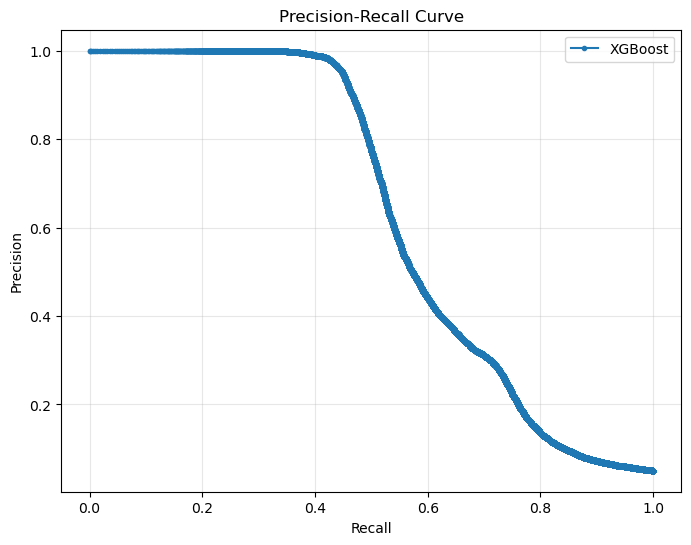

In [20]:
# Precision-Recall Curve
# Generate precision and recall values
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label="XGBoost")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

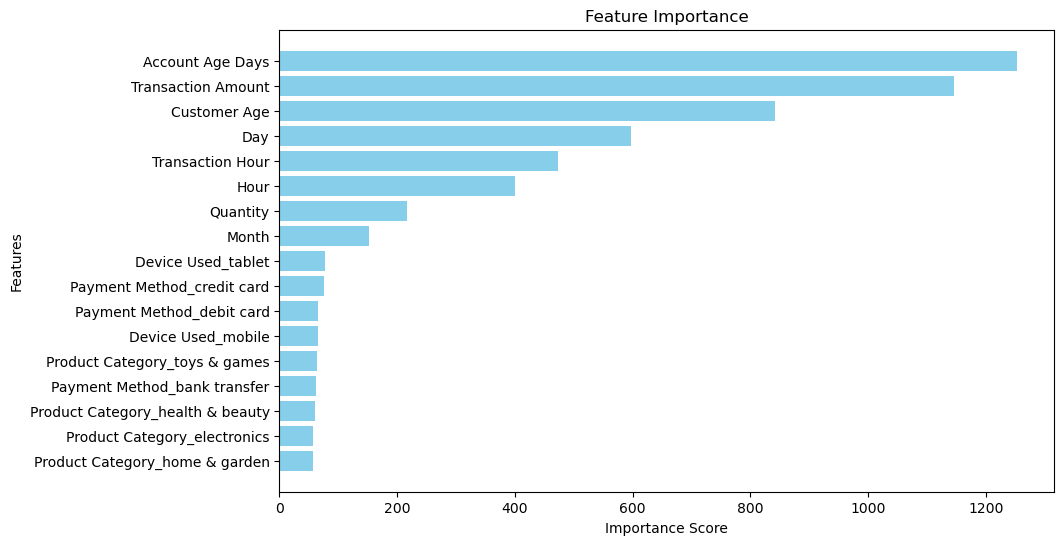

In [21]:
# Feature Importance Plot
# Retrieve feature names
feature_names = X_train.columns

# Get feature importance
feature_importance = model.get_booster().get_score(importance_type='weight')

# Map feature names
mapped_feature_importance = {feature_names[int(k[1:])]: v for k, v in feature_importance.items()}

# Sort and plot
sorted_importance = sorted(mapped_feature_importance.items(), key=lambda x: x[1], reverse=True)
features, scores = zip(*sorted_importance)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features, scores, color='skyblue')
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()  # Most important features at the top
plt.show()

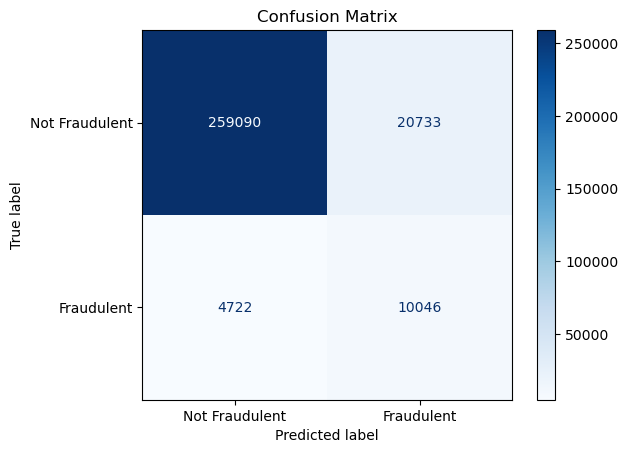

In [22]:
# Confusion Matrix Heatmap
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraudulent", "Fraudulent"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

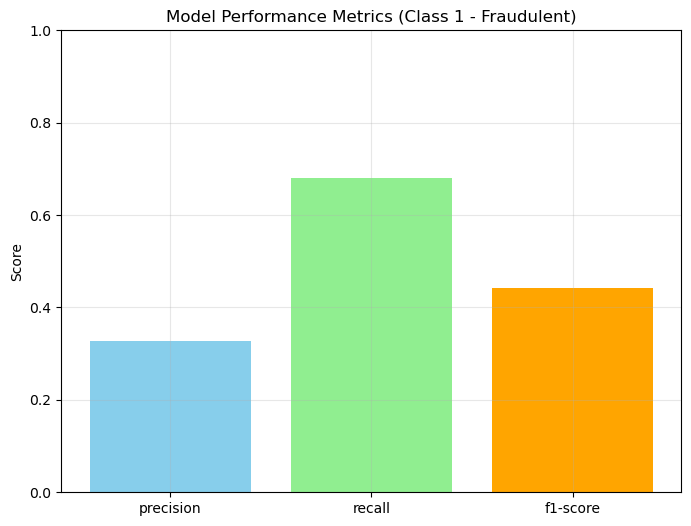

In [23]:
# Classification Report Visualization
# Get classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Extract metrics for "Class 1" (Fraudulent)
metrics = ["precision", "recall", "f1-score"]
values = [report["1"][metric] for metric in metrics]

# Plot the metrics
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=["skyblue", "lightgreen", "orange"])
plt.title("Model Performance Metrics (Class 1 - Fraudulent)")
plt.ylabel("Score")
plt.ylim(0, 1)  # Scores range between 0 and 1
plt.grid(alpha=0.3)
plt.show()